In [1]:
#using Revise
using DrWatson
@quickactivate "ABoxWorld"
include(srcdir("ABoxWorld.jl"));

┌ Info: ABoxWorld project environment is loaded and active
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\src\ABoxWorld.jl:10


LoadError: LoadError: ParseError:
# Error @ s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\src\common_conditions.jl:263:14
    b = [CHSHprime_score_val, CHSH_score_val, 1]
    return A \ b # Equiv. to np.linalg.solve(A, b)
#            └┘ ── invalid escape sequence
in expression starting at s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\src\common_conditions.jl:263
in expression starting at s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\src\ABoxWorld.jl:16

In [2]:

using LinearAlgebra
using TensorOperations
using Parameters
using CairoMakie
CairoMakie.activate!()
#using GLMakie
#GLMakie.activate!()


In [3]:

convert_matrixbox_to_nsjoint = wirings.convert_matrixbox_to_nsjoint
convert_nsjoint_to_matrixbox = wirings.convert_nsjoint_to_matrixbox


# Boxes as 2x2x2x2 tensors
MaxMixedBox = nsboxes.reconstructFullJoint(UniformRandomBox((2, 2, 2, 2)))
PR(μ, ν, σ) = nsboxes.reconstructFullJoint(PRBoxesCHSH(;μ=μ, ν=ν, σ=σ))
CanonicalPR = PR(0, 0, 0)
PL(α, γ, β, λ) = nsboxes.reconstructFullJoint(LocalDeterministicBoxesCHSH(;α=α, γ=γ, β=β, λ=λ))
SR = (PL(0,0,0,0) .+ PL(0,1,0,1)) ./ 2
#SR = matrix_to_tensor(non_local_boxes.utils.SR)
#PRprime = matrix_to_tensor(non_local_boxes.utils.PRprime)
#P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
#P1 = matrix_to_tensor(non_local_boxes.utils.P_1)


CHSH_score = games.canonical_CHSH_score
#CHSHprime_score = games.CHSH_score_generator(-1,1,1,1; batched=false)
CHSHprime_score = games.CHSH_score_generator(1,-1,1,1; batched=false)


BoxProduct = wirings.tensorized_boxproduct
reduc_BoxProduct = wirings.reduc_tensorized_boxproduct
BoxProduct_matrices(w::Matrix{<:Real}, matrixbox1::Matrix{Float64}, matrixbox2::Matrix{Float64}) = convert_nsjoint_to_matrixbox(reduc_BoxProduct(w, matrixbox1, matrixbox2))


IC_Bound = Original_IC_Bound()
IC_Bound_LHS(P::Array{Float64, 4}) = conditions.evaluate(IC_Bound, P)
IC_Bound_LHS(W::Matrix{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)
IC_Bound_LHS(W::Vector{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)

IC_MutInfo = games.MutInfo_IC_vanDam_score



MutInfo_IC_vanDam_score (generic function with 5 methods)

In [4]:

function Compute_Coeff(P1::Array{Float64,4}, P2::Array{Float64,4}, P3::Array{Float64,4}, alt_G_score_val::Real, CHSH_score_val::Real, alt_Game_score::Function) # P1, P2, P3 are 2x2x2x2 tensors
    A = [alt_Game_score(P1) alt_Game_score(P2) alt_Game_score(P3);
           CHSH_score(P1)     CHSH_score(P2)     CHSH_score(P3);
                1                    1                1           ]
    b = [alt_G_score_val, CHSH_score_val, 1]
    return A \ b # Equiv. to np.linalg.solve(A, b)
end


function is_in_NPA_TLM(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    #return conditions.check(NPA_TLM_Criterion(), Box)

    E_xy = ProbBellCorrelator(Box)
    coeff00 = asin(E_xy[1,1])
    coeff01 = asin(E_xy[1,2])
    coeff10 = asin(E_xy[2,1])
    coeff11 = asin(E_xy[2,2])
    return coeff00 + coeff01 + coeff10 - coeff11 <= pi
end



function is_in_NPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_in_NPA(Box; level=level, verbose=false)    
end



function is_asymp_in_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_asymp_in_pyNPA(Box; level=level, verbose=false)
end


function is_in_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_in_pyNPA(Box; level=level, verbose=false)
end

function min_distance_to_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    p_obs = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.min_distance_to_pyNPA(p_obs; level=level, verbose=false)
end

    
function nearest_pyNPA_point(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    p_obs = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.nearest_pyNPA_point(p_obs; level=level, verbose=false)
end

is_NOT_in_IC(P::Array{Float64,4}) = !(conditions.check(Original_IC_Bound(), P, :Q))
#is_NOT_in_IC(P::Array{Float64,4}) = !(conditions.check(Generalized_Original_IC_Bound(), P, :Q))

function is_NOT_in_IC(secondary_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, secondary_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, secondary_score_val, CHSH_score_val, secondary_score)
    MixedBox = α*Box1 + β*Box2 + γ*Box3
    
    return is_NOT_in_IC(MixedBox)
    #return conditions.check(Generalized_Original_IC_Bound(), MixedBox, :Q)
end

is_NOT_in_Uffink(P::Array{Float64,4}) = !(conditions.check(Uffink_Bipartite_2222_Inequality(), P, :Q))

function is_NOT_in_Uffink(secondary_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, secondary_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, secondary_score_val, CHSH_score_val, secondary_score)
    MixedBox = α*Box1 + β*Box2 + γ*Box3
    
    return is_NOT_in_Uffink(MixedBox)
    #return conditions.check(Uffink_Bipartite_2222_Inequality(), MixedBox, :Q)
end


#is_NOT_in_RedundantIC(P::Array{Float64,4}) = !(conditions.check(Limited_RedundantInfo_IC_Bound(), P, :Q))
is_NOT_in_RedundantIC(P::Array{Float64,4}) = !(conditions.check(RedundantInfo_IC_Bound(), P, :Q))

function is_NOT_in_RedundantIC(secondary_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, secondary_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, secondary_score_val, CHSH_score_val, secondary_score)
    MixedBox = α*Box1 + β*Box2 + γ*Box3
    
    return is_NOT_in_RedundantIC(MixedBox)
end


is_NOT_in_RedundantIC (generic function with 2 methods)

In [5]:
@with_kw struct WiringsSlicePlotConfig
    Box1::Pair{String, Array{Float64,4}}
    Box2::Pair{String, Array{Float64,4}}
    Box3::Pair{String, Array{Float64,4}}
    primary_score::Function = CHSH_score
    secondary_score::Function
    IC_violation_criterion::Function = is_NOT_in_IC
    boundary_precision::Float64
    precision::Float64
end

WiringsSlicePlotConfig

In [6]:
function Wirings_Slice_Plot(config::WiringsSlicePlotConfig; verbose::Bool=false)

    results = Dict(string(key) => getfield(config, key) for key in fieldnames(WiringsSlicePlotConfig))

    is_NOT_in_IC = config.IC_violation_criterion

    P1, P2, P3 = config.Box1.second, config.Box2.second, config.Box3.second
    secondary_score = config.secondary_score

    # Draw the initial background triangle:
    x1, y1 = secondary_score(P1), CHSH_score(P1) #Stays CHSH because it's the coordinate system of the plot, also in IC
    x2, y2 = secondary_score(P2), CHSH_score(P2)
    x3, y3 = secondary_score(P3), CHSH_score(P3)
    ns_extremes = [(x1, y1), (x2, y2), (x3, y3)]
    results["ns_extremes"] = ns_extremes

    # Check if our coordinate system is good, i.e. if projected points aren't aligned (= allow 2D viz.):
    ( (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3) ) && error("We can't make a 2D plot from a 0D or 1D space of points.")


    
    # Compute the Quantum boundary:
    println("Computing Quantum boundary...")
    membership_level = 3
    c_secondary_score_val=min(x2,x3) #Initialize at x-axis origin
    c_CHSH_score_val=4 #Safely initialize at the maximum local value of CHSH
    results["quantum_secondary_scores"] = Float64[]
    results["quantum_primary_scores"] = Float64[]
    while c_secondary_score_val <= max(x2, x3)
        if is_in_NPA(c_secondary_score_val, c_CHSH_score_val, P1, P2, P3, secondary_score, membership_level) 
            push!(results["quantum_secondary_scores"], c_secondary_score_val)
            push!(results["quantum_primary_scores"], c_CHSH_score_val)
            c_secondary_score_val += config.boundary_precision
        else 
            if c_CHSH_score_val - config.boundary_precision > y2  #Still on the canvas of our viz.
                c_CHSH_score_val -= config.boundary_precision
            else
                c_CHSH_score_val=y2 #Take the canvas lower-boundary as the quantum boundary (even if it's not in the Q set) 
                c_secondary_score_val += config.boundary_precision # Go to the next point along x-axis / vertical line 
            end
        end
    end

    
    # Compute the IC boundary:
    println("Computing IC boundary...")
    algebraic_max_CHSH_score = 4.0
    min_secondary_score = 0.0
    c_secondary_score_val = min(x2,x3) #Reset x-axis pointer to smallest value on the x-axis
    init_CHSH_guess = 2.0
    c_CHSH_score_val = init_CHSH_guess
    #In this scenario, need to ensure that Quantum and IC boundaries are aligned
    results["IC_secondary_scores"] = copy(results["quantum_secondary_scores"]) #Float64[]
    results["IC_primary_scores"] = Union{Float64, Missing}[]
    #
    for c_secondary_score_val in results["IC_secondary_scores"] 
        while c_CHSH_score_val <= algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score #Check whether still within NS region; equiv. to whether there still is a pair of (G, CHSH) that can be in the NS region

            if is_NOT_in_IC(c_secondary_score_val, c_CHSH_score_val, P1, P2, P3, secondary_score)
                push!(results["IC_primary_scores"], c_CHSH_score_val)
                c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange (linear?) interpolation on plot origin (0.75, 0.75) and (0.5, init_CHSH_guess) for x-point of next iteration; Set new initial y-value to 
                break # Success, so move on to next point along x-axis
                #That's because, Above CHSH guess does not work if boundary happens to be concave! (might guess to high -> too loose boundary)
            else
                if c_CHSH_score_val + config.boundary_precision < (algebraic_max_CHSH_score-c_secondary_score_val)
                    if c_secondary_score_val > 0.12 && c_CHSH_score_val > 3.5
                        @show c_CHSH_score_val
                    end
                    c_CHSH_score_val += config.boundary_precision #Stay at same x-point, but go up along y-axis
                else 
                    #Accept that we're at the boundary of the NS region and move on to the next x-point
                    #push!(results["IC_primary_scores"], missing) #Add the NS boundary point to the list
                    push!(results["IC_primary_scores"], algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score) #Add the NS boundary point to the list
                    c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange interpolation; Same as in comment above
                    break
                end
            end
        end
    end

    
    # Compute the Redundant-IC Boundary
    println("Computing Redundant_IC boundary...")
    algebraic_max_CHSH_score = 4.0
    min_secondary_score = 0.0
    c_secondary_score_val = min(x2,x3) #Reset x-axis pointer to smallest value on the x-axis
    init_CHSH_guess = 2.0
    c_CHSH_score_val = init_CHSH_guess
    #In this scenario, need to ensure that Quantum and IC boundaries are aligned
    results["Redundant_IC_secondary_scores"] = copy(results["quantum_secondary_scores"]) #Float64[]
    results["Redundant_IC_primary_scores"] = Union{Float64, Missing}[]
    #
    for c_secondary_score_val in results["Redundant_IC_secondary_scores"] 
        while c_CHSH_score_val <= algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score #Check whether still within NS region; equiv. to whether there still is a pair of (G, CHSH) that can be in the NS region

            if is_NOT_in_RedundantIC(c_secondary_score_val, c_CHSH_score_val, P1, P2, P3, secondary_score)
                push!(results["Redundant_IC_primary_scores"], c_CHSH_score_val)
                c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange (linear?) interpolation on plot origin (0.75, 0.75) and (0.5, init_CHSH_guess) for x-point of next iteration; Set new initial y-value to 
                break # Success, so move on to next point along x-axis
                #That's because, Above CHSH guess does not work if boundary happens to be concave! (might guess to high -> too loose boundary)
            else
                if c_CHSH_score_val + config.boundary_precision < (algebraic_max_CHSH_score-c_secondary_score_val)
                    if c_secondary_score_val > 0.12 && c_CHSH_score_val > 3.5
                        @show c_CHSH_score_val
                    end
                    c_CHSH_score_val += config.boundary_precision #Stay at same x-point, but go up along y-axis
                else 
                    #Accept that we're at the boundary of the NS region and move on to the next x-point
                    push!(results["Redundant_IC_primary_scores"], algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score) #Add the NS boundary point to the list
                    c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange interpolation; Same as in comment above
                    break
                end
            end
        end
    end
    


    return results
end

Wirings_Slice_Plot (generic function with 1 method)

In [7]:


"""
c_config = WiringsSlicePlotConfig(Box1=("PR"=>CanonicalPR),
                                Box2=("I"=>MaxMixedBox),
                                Box3=("PL(0,0,0,0)"=>PL(0,0,0,0)),
                                #Box3=("PL(0,1,0,1)"=>PL(0,1,0,1)),
                                primary_score=CHSH_score,
                                secondary_score=CHSHprime_score,
                                IC_violation_criterion = is_NOT_in_IC, 
                                boundary_precision=4e-3,
                                precision=1.4e-2,
                                )
"""

#CHSHprime_score = games.CHSH_score_generator(-1,1,1,1; batched=false)

c_config = WiringsSlicePlotConfig(Box1=("PR"=>CanonicalPR),
                                Box2=("I"=>MaxMixedBox),
                                #Box3=("PL(0,0,0,0)"=>PL(0,0,0,0)),
                                #Box3=("PR(0,1,0)"=>PR(0,1,0)),
                                #Box3=("PR(1,1,0)"=>PR(1,1,0)),
                                Box3=("PL(0,1,0,1)"=>PL(0,1,0,1)),
                                primary_score=CHSH_score,
                                secondary_score=CHSHprime_score,
                                IC_violation_criterion = is_NOT_in_IC, 
                                boundary_precision=4e-3,
                                precision=1.4e-2,
                                )

    
data_output = Wirings_Slice_Plot(c_config; verbose=true)

                


Computing Quantum boundary...
Computing IC boundary...
Computing Redundant_IC boundary...
Total mutual info: 3.606737752903655e-7
Total redundant info: 0.0
Total info: 3.606737752903655e-7
Total mutual info: 3.621179125445906e-7
Total redundant info: 0.0
Total info: 3.621179125445906e-7
Total mutual info: 3.635649363786797e-7
Total redundant info: 0.0
Total info: 3.635649363786797e-7
Total mutual info: 3.65014845016276e-7
Total redundant info: 0.0
Total info: 3.65014845016276e-7
Total mutual info: 3.664676384573795e-7
Total redundant info: 0.0
Total info: 3.664676384573795e-7
Total mutual info: 3.6792331847834703e-7
Total redundant info: 0.0
Total info: 3.6792331847834703e-7
Total mutual info: 3.6938188330282173e-7
Total redundant info: 0.0
Total info: 3.6938188330282173e-7
Total mutual info: 3.708433329308036e-7
Total redundant info: 0.0
Total info: 3.708433329308036e-7
Total mutual info: 3.7230766913864954e-7
Total redundant info: 0.0
Total info: 3.7230766913864954e-7
Total mutual in

Excessive output truncated after 524289 bytes.

Total mutual info: 4.755873324047144e-7
Total redundant info: 1.7638236005153188e-9
Total info: 4.738235088041991e-7
Total mutual info: 4.772421040577512e-7
Total redundant info: 1.763877500521793e-9
Total info: 4.7547822655722946e-7
Total mutual info: 4.788997602922507e-7
Total redundant info: 1.7639216005230858e-9
Total info: 4.771358386917276e-7
Total mutual info: 4.805603026625249e-7
Total redundant info: 1.7639559005124211e-9
Total info: 4.787963467620125e-7
Total mutual info: 4.822237302803956e-7
Total redundant info: 1.7639804560348315e-9
Total info: 4.804597498243607e-7
Total mutual info: 4.838900431458626e-7
Total redundant info: 1.7639951005195937e-9
Total info: 4.82126048045343e-7
Total mutual info: 4.855592419250598e-7
Total redundant info: 1.7639998894947997e-9
Total info: 4.83795242035565e-7
Total mutual info: 4.872313250636751e-7
Total redundant info: 1.7639951560256627e-9
Total info: 4.854673299076494e-7
Total mutual info: 4.889062945601097e-7
Total redundant info: 1.76

Dict{String, Any} with 15 entries:
  "Redundant_IC_secondary_scores" => [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.…
  "secondary_score"               => abs_CHSH_score
  "IC_secondary_scores"           => [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.…
  "precision"                     => 0.014
  "IC_primary_scores"             => Union{Missing, Float64}[2.832, 2.832, 2.83…
  "quantum_primary_scores"        => [2.828, 2.824, 2.824, 2.82, 2.82, 2.82, 2.…
  "Box3"                          => "PL(0,1,0,1)"=>[0.0 0.0; 0.0 1.0;;; 0.0 0.…
  "IC_violation_criterion"        => is_NOT_in_IC
  "boundary_precision"            => 0.004
  "primary_score"                 => canonical_CHSH_score
  "Redundant_IC_primary_scores"   => Union{Missing, Float64}[2.832, 2.832, 2.83…
  "Box1"                          => "PR"=>[0.5 0.0; 0.0 0.5;;; 0.5 0.0; 0.0 0.…
  "quantum_secondary_scores"      => [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.…
  "Box2"                          => "I"=>[0.25 0.25; 0.25 0.25;;; 0.25

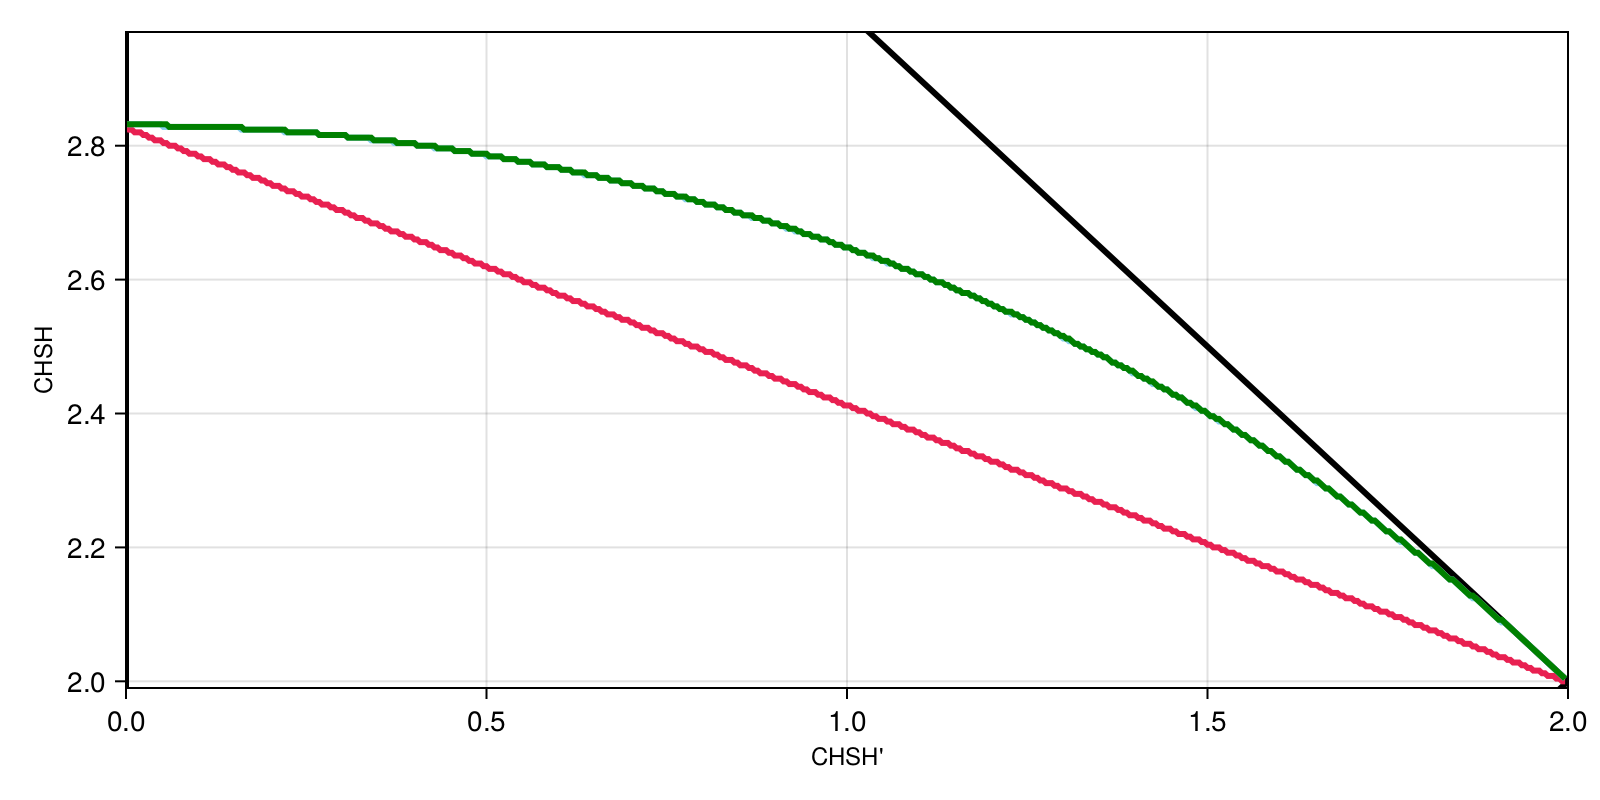

In [8]:
function plot_Slice_Bounds(data::Dict; markersize::Real=4, big::Bool=true)

    # Initialize figure and colors:
    IC_color = :skyblue
    Redundant_IC_color = :green
    NS_color = :black
    Quantum_color = "#e82051"
    
    fig = Figure(; size=(800,400))
    
    ax = Axis(fig[1, 1]; xlabel = "CHSH'", ylabel = "CHSH", xlabelsize=(big ? 12 : 10), ylabelsize=(big ? 12 : 10),
            #titlevisible=title_visible, titlesize=(big ? 15 : 12.5), title =L"IC Violating Boxes ($K_{{reset}}$=%$(K_reset), χ=%$(χ), m=$10^%$(Int(log10(m)))$, M=%$(LS_iterations), N=%$(max_power)).",
            )
    xlims!(ax, min(map(first, data["ns_extremes"])...), max(map(first, data["ns_extremes"])...))
    #ylims!(ax, min(y1, y2, y3), max(y1, y2, y3))
    #ylims!(ax, 1.5, 4)
    ylims!(ax, 1.99, 2.1*sqrt(2))

    
    #Draw the Boundary of the NS set:
    ns_boundary_line = lines!(ax, [map(first, data["ns_extremes"])..., data["ns_extremes"][1][1]], [map(last, data["ns_extremes"])..., data["ns_extremes"][1][end]]; color=NS_color, linewidth=3)

    #Draw the Quantum boundary:
    quantum_boundary_line = lines!(ax, data["quantum_secondary_scores"], data["quantum_primary_scores"]; color=Quantum_color, linewidth=3)

    #Draw the unwired IC boundary:
    IC_boundary_line = lines!(ax, data["IC_secondary_scores"], data["IC_primary_scores"]; color=IC_color, linewidth=3)

    #middle_points_IC_Q = data["quantum_primary_scores"][1:end-(length(data["quantum_secondary_scores"])-length(data["IC_secondary_scores"]))] + (data["IC_primary_scores"] - data["quantum_primary_scores"][1:end-(length(data["quantum_secondary_scores"])-length(data["IC_secondary_scores"]))]) ./ 2 
    #lines!(ax, data["IC_secondary_scores"], middle_points_IC_Q; color="black", linestyle=:dash, linewidth=1.5)
    
    #Draw the Redundant IC boundary:
    Redundant_IC_boundary_line = lines!(ax, data["Redundant_IC_secondary_scores"], data["Redundant_IC_primary_scores"]; color=Redundant_IC_color, linewidth=3)

    #Misc. plot settings:
        
    legend_visible = true
    legend_visible ? (axislegend(ax, [ns_boundary_line, quantum_boundary_line, IC_boundary_line, Redundant_IC_boundary_line],
                                ["NS boundary","Quantum boundary", "Pawlowski2009", "Yu2022"];
                                position = :rt, labelsize = (big ? 10.5 : 9.5) )) : nothing
    
    fig # equiv. to plt.show()
end

plot_Slice_Bounds(data_output ;markersize=10,)